# Contents

----

----

__This notebook investigates the dataset derived from `Ming et al.` (race-cancer correlation 0.025). Inductive Conformal Predictors are applied to underlying classifiers: `ADA`, `RF`, `LR`, and `KNN`.__

$H_0$ = There is no difference in the proportion of `Race` in the Lower Decile Range of predictions, based on confidence/credibility, compared to the population sample.

$H_a$ = There is a difference in the proportion of `Race` in the Lower Decile Range of predictions, based on confidence/credibility, compared to the population sample.

----

In [1]:
import os

# set pwd to root of repository
repo_root = 'C:/Users/Bob/CHPC/conformal_prediction/vigilant-computing-machine/'
#repo_root = '/uufs/chpc.utah.edu/common/home/u0740821/conformal_prediction/vigilant-computing-machine'

os.chdir(repo_root)

In [2]:
# 'vigilant-computing-machine/source/util.py'
import source.util as util

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

import Orange
from Orange.distance import Euclidean
import orangecontrib.conformal as cp

# read in data

In [3]:
normalizer = Orange.preprocess.Normalizer(norm_type = Orange.preprocess.Normalize.NormalizeBySD)
tab_signal = normalizer(Orange.data.Table('./data/signal_with_header_for_orange.csv'))

----
Get `Race` distribution in population sample

In [4]:
tab_signal.domain

[T1, N_Biop, HypPlas, AgeMen, Age1st, N_Rels, Race | Case_signalYN]

In [38]:
df_race_signal = pd.DataFrame()
df_race_signal['race'] = tab_signal.X[:,-1]
df_race_signal['race'] = df_race_signal['race'].astype(int)
df_race_signal_counts = df_race_signal.value_counts().sort_index()
n_signal_race = df_race_signal_counts.values.sum()
df_race_signal_prop = pd.DataFrame({'prevalence': df_race_signal_counts / n_signal_race,'prevalence_n': df_race_signal_counts})
df_race_signal_prop

,prevalence,prevalence_n
race,,
0,0.490833,589
1,0.195000,234
2,0.216667,260
3,0.078333,94
4,0.014167,17
5,0.003333,4
6,0.001667,2


----

In [6]:
np.random.seed(42)


train, test = next(cp.evaluation.RandomSampler(tab_signal,2,1))
train, calibrate = next(cp.evaluation.RandomSampler(train,2,1))

cc=cp.classification.InductiveClassifier(
    cp.nonconformity.InverseProbability(
        Orange.classification.LogisticRegressionLearner()))

experiment_logistic = util.run_experiments(cc, train, test, calibrate, times=1)

In [7]:
experiment_logistic

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,conformal_predictor,nonconformity,method,model,instance_of_model,df
0,0.986101,0.497341,0.935,0.0,1.0,0.935,0.0,signal_with_header_for_orange,False,logistic regression,InductiveClassifier (InverseProbability (logis...,InverseProbability (logistic regression),,LogisticRegressionClassifier(skl_model=Logisti...,InductiveClassifier (InverseProbability (logis...,classes confidence credibility eps \ 0...


,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,conformal_predictor,nonconformity,method,model,instance_of_model,df
0,0.986101,0.497341,0.935,0.0,1.0,0.935,0.0,signal_with_header_for_orange,False,logistic regression,InductiveClassifier (InverseProbability (logis...,InverseProbability (logistic regression),,LogisticRegressionClassifier(skl_model=Logisti...,InductiveClassifier (InverseProbability (logis...,classes confidence credibility eps \ 0...


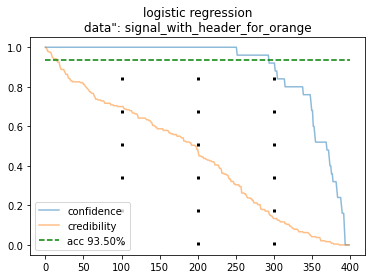

In [8]:
util.plot_experiments(experiment_logistic)
experiment_logistic

In [9]:
df_cpred_logistic = experiment_logistic.loc[0, 'df']
df_cpred_logistic.head(3)

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
0,[1],0.992537,0.335821,0.1,"[(0.007462686567164179, 0), (0.335820895522388...",True,0.482929,0,2,-0.440587,-0.474771,2,0,1
1,[0],0.996269,0.626866,0.1,"[(0.6268656716417911, 0), (0.00373134328358208...",True,-0.712357,0,2,-0.440587,2.040345,0,1,0
2,[1],0.951493,0.130597,0.1,"[(0.048507462686567165, 0), (0.130597014925373...",False,-0.114714,1,1,0.517210,-0.509225,0,0,0


In [10]:
df_cpred_logistic_sorted = util.sort_reindex(df_cpred_logistic, col=['confidence','credibility'])
df_cpred_logistic_sorted.head(3)

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
0,[0],0.996269,0.996269,0.1,"[(0.996268656716418, 0), (0.003731343283582089...",True,-2.903715,0,2,0.51721,-0.543679,0,0,0
1,[1],0.996269,0.992537,0.1,"[(0.0037313432835820895, 0), (0.99253731343283...",True,2.674286,0,2,0.51721,-0.440318,0,2,1
2,[1],0.996269,0.988806,0.1,"[(0.0037313432835820895, 0), (0.98880597014925...",True,2.674286,0,2,0.51721,2.040345,0,0,1


----
Get decile index

In [11]:
ld_idx = int(len(df_cpred_logistic_sorted.index.values) / 10)
ld_idx

40

---
Get Lower Decile Range (LDR) - lowest 10th percentile `confidence`/`credibility`

In [12]:
df_cpred_logistic_ldr = df_cpred_logistic_sorted.iloc[-ld_idx:,:]
df_cpred_logistic_ldr.head(3)

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
360,[0],0.951493,0.134328,0.1,"[(0.13432835820895522, 0), (0.0485074626865671...",True,-0.114714,0,2,1.475007,2.040345,1,0,0
361,[1],0.951493,0.130597,0.1,"[(0.048507462686567165, 0), (0.130597014925373...",False,-0.114714,1,1,0.517210,-0.509225,0,0,0
362,[0],0.951493,0.119403,0.1,"[(0.11940298507462686, 0), (0.0485074626865671...",False,0.084500,0,2,-1.398384,-0.509225,0,0,1


In [13]:
df_cpred_logistic_ldr.tail(3)

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
397,[0],0.902985,0.100746,0.1,"[(0.10074626865671642, 0), (0.0970149253731343...",False,-0.114714,0,2,0.51721,-0.543679,3,2,1
398,[0],0.902985,0.100746,0.1,"[(0.10074626865671642, 0), (0.0970149253731343...",True,0.084500,0,2,0.51721,-0.543679,0,0,0
399,[0],0.902985,0.100746,0.1,"[(0.10074626865671642, 0), (0.0970149253731343...",True,0.084500,0,2,0.51721,-0.543679,0,0,0


----
Get `Race` distribution in 10% lowest confidence region

In [14]:
logistic_ldr_race_counts = df_cpred_logistic_ldr.Race.value_counts().sort_index()
logistic_ldr_race_counts

0    22
1     8
2     7
3     3
Name: Race, dtype: int64

----
Normalize

In [37]:
n_logistic_ldr_race = logistic_ldr_race_counts.values.sum()
logistic_ldr_race_prop = pd.DataFrame({'low_confidence': logistic_ldr_race_counts / n_logistic_ldr_race, 
                                       'low_confidence_n': logistic_ldr_race_counts})
logistic_ldr_race_prop

,low_confidence,low_confidence_n
0,0.550,22
1,0.200,8
2,0.175,7
3,0.075,3


----
Combine

In [40]:
df_logistic_ldr_race_disparity = df_race_signal_prop.join(logistic_ldr_race_prop, on='race', how='left')
df_logistic_ldr_race_disparity = df_logistic_ldr_race_disparity.fillna(0)
df_logistic_ldr_race_disparity['low_confidence_n'] = df_logistic_ldr_race_disparity['low_confidence_n'].astype(int)
df_logistic_ldr_race_disparity

,prevalence,prevalence_n,low_confidence,low_confidence_n
race,,,,
0,0.490833,589,0.550,22
1,0.195000,234,0.200,8
2,0.216667,260,0.175,7
3,0.078333,94,0.075,3
4,0.014167,17,0.000,0
5,0.003333,4,0.000,0
6,0.001667,2,0.000,0


----
Test Hypothesis

In [18]:
df_cpred_logistic_ldr

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
360,[0],0.951493,0.134328,0.1,"[(0.13432835820895522, 0), (0.0485074626865671...",True,-0.114714,0,2,1.475007,2.040345,1,0,0
361,[1],0.951493,0.130597,0.1,"[(0.048507462686567165, 0), (0.130597014925373...",False,-0.114714,1,1,0.517210,-0.509225,0,0,0
362,[0],0.951493,0.119403,0.1,"[(0.11940298507462686, 0), (0.0485074626865671...",False,0.084500,0,2,-1.398384,-0.509225,0,0,1
363,[0],0.951493,0.119403,0.1,"[(0.11940298507462686, 0), (0.0485074626865671...",True,0.084500,0,2,-0.440587,-0.509225,0,1,0
364,[0],0.951493,0.119403,0.1,"[(0.11940298507462686, 0), (0.0485074626865671...",False,0.084500,0,2,-1.398384,-0.440318,0,0,1
365,[0],0.951493,0.119403,0.1,"[(0.11940298507462686, 0), (0.0485074626865671...",True,-0.114714,0,2,0.517210,2.040345,0,2,0
366,[0],0.951493,0.119403,0.1,"[(0.11940298507462686, 0), (0.0485074626865671...",True,0.084500,0,2,-0.440587,-0.509225,0,1,0
367,[1],0.951493,0.119403,0.1,"[(0.048507462686567165, 0), (0.119402985074626...",True,0.084500,0,2,0.517210,-0.509225,2,0,1
368,[1],0.951493,0.115672,0.1,"[(0.048507462686567165, 0), (0.115671641791044...",False,0.084500,0,2,0.517210,-0.440318,0,2,0
369,[0],0.951493,0.115672,0.1,"[(0.11567164179104478, 0), (0.0485074626865671...",True,-0.114714,0,2,0.517210,-0.509225,1,2,0


----
Plot population race distribution

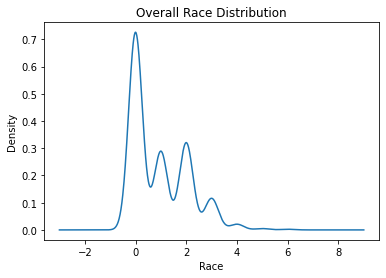

In [60]:
pop_race = df_race_signal['race']
pop_race.plot(kind='density', title='Overall Race Distribution')
plt.xlabel('Race')
print()

----
Plot prediction Lower Decile Range (confidence) distribution

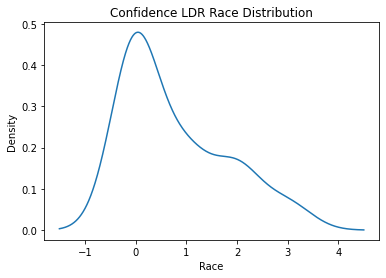

In [59]:
ldr_race = df_cpred_logistic_ldr.Race
ldr_race.plot(kind='density', title='Confidence LDR Race Distribution')
plt.xlabel('Race')
print()

Shapiro-Wilk Normality Test
----
$H_0$ = the data was drawn from a normal distribution

In [24]:
stats.shapiro(pop_race)

ShapiroResult(statistic=0.7941691875457764, pvalue=1.895033534699303e-36)

In [25]:
stats.shapiro(ldr_race)

ShapiroResult(statistic=0.7528342008590698, pvalue=8.066829764175054e-07)

__Conclusion__:

Both the population-race distribution and the prediction-confidence LDR race distribution fail the Shapiro-Wilk Normality test.

We will have to use a non-parametric test.

In [26]:
stats.variation(pop_race)

1.1765201075964045

In [27]:
stats.variation(ldr_race)

1.2736830337032021

$H_0$ = all input samples are from populations with equal variances

In [32]:
stats.levene(pop_race, ldr_race)

LeveneResult(statistic=2.2678878011041803, pvalue=0.13233490083395943)

We fail to rejected the null hypothesis that samples have equal variance

In [33]:
stats.mannwhitneyu(pop_race, ldr_race)

MannwhitneyuResult(statistic=25812.0, pvalue=0.3813075237168556)

The above test is incorrect, as `Race` is not ordinal
----

In [61]:
# stats.ttest_ind_from_stats?

# Signature:
# stats.ttest_ind_from_stats(
#     mean1,
#     std1,
#     nobs1,
#     mean2,
#     std2,
#     nobs2,
#     equal_var=True,
#     alternative='two-sided',
# )
# Docstring:
# T-test for means of two independent samples from descriptive statistics.

# This is a two-sided test for the null hypothesis that two independent
# samples have identical average (expected) values.

In [47]:
# need std for this test
for i, row in df_logistic_ldr_race_disparity.iterrows():
    print(f'Race = {i}')
    print(stats.ttest_ind_from_stats(mean1=row.prevalence, std1=1, nobs1=row.prevalence_n, 
                                     mean2=row.low_confidence, std2=1, nobs2=row.low_confidence_n))

Race = (0,)
Ttest_indResult(statistic=-0.27247426224527455, pvalue=0.7853497366259188)
Race = (1,)
Ttest_indResult(statistic=-0.01390641685525306, pvalue=0.9889161954169475)
Race = (2,)
Ttest_indResult(statistic=0.10878495128601415, pvalue=0.9134553857414007)
Race = (3,)
Ttest_indResult(statistic=0.005683520519737914, pvalue=0.9954771490907556)
Race = (4,)
Ttest_indResult(statistic=0.0, pvalue=1.0)
Race = (5,)
Ttest_indResult(statistic=0.0, pvalue=1.0)
Race = (6,)
Ttest_indResult(statistic=nan, pvalue=nan)


In [43]:
df_logistic_ldr_race_disparity

,prevalence,prevalence_n,low_confidence,low_confidence_n
race,,,,
0,0.490833,589,0.550,22
1,0.195000,234,0.200,8
2,0.216667,260,0.175,7
3,0.078333,94,0.075,3
4,0.014167,17,0.000,0
5,0.003333,4,0.000,0
6,0.001667,2,0.000,0


In [416]:
pred = df[~df.verdict].sort_values(by=['confidence','credibility']).iloc[2,:]
pred

classes                      [1]
confidence              0.921642
credibility             0.100746
verdict                    False
Race                           2
class                          0
class_0                        7
class_1                        6
confidence_ensemble     0.617804
credibility_ensemble    0.662047
Name: 191, dtype: object

In [16]:
import plotly.graph_objects as go

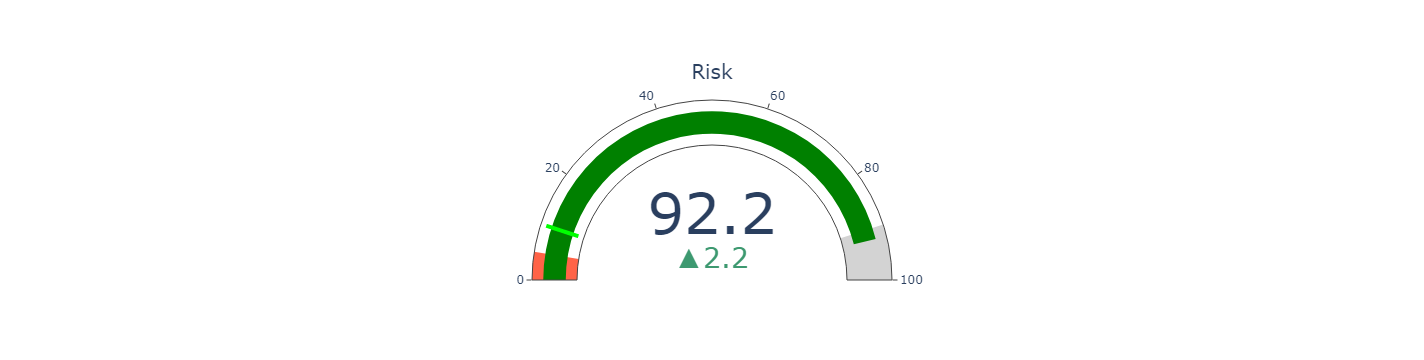

In [454]:
min_cred = 5
min_conf = 90
conf = pred.confidence*100
cred = pred.credibility*100
second_most_cred = (1 - pred.credibility) * 100
cred_threshold_clr = 'red' if cred < min_cred else 'lime'
conf_color = 'red' if conf < min_conf else 'green'

fig =go.Figure(go.Indicator(
    domain={'x': [0, 1], 'y': [0, 1]},
    value=conf,
    mode='gauge+number+delta',
    title={'text':'Risk'},
    delta={'reference':second_most_cred},
    gauge={'axis': {'range': [None,100]},
           'steps': [
               {'range': [0,min_cred], 'color': 'tomato'},
               {'range': [min_conf,100], 'color': 'lightgray'}],
           'threshold': {'line': {'color': cred_threshold_clr, 'width': 4}, 'thickness': 0.75, 'value': cred}}))
fig.show()

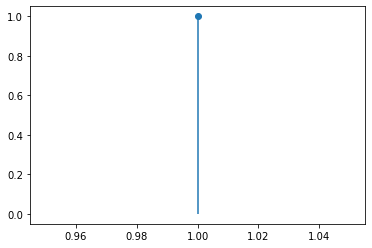

In [171]:
fig,ax = plt.subplots()
plt.stem(1,1)
plt.stem?

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
82,[],0.917910,0.089552,0.1,"[(0.08208955223880597, 0), (0.0895522388059701...",False,0.500000,0,2,0.285714,0.038462,2,3,0
116,[],0.917910,0.097015,0.1,"[(0.09701492537313433, 0), (0.0820895522388059...",False,0.500000,0,2,0.571429,1.000000,0,0,1
191,[1],0.921642,0.100746,0.1,"[(0.07835820895522388, 0), (0.1007462686567164...",False,0.470588,0,2,0.714286,0.051282,1,2,0
85,[1],0.929104,0.108209,0.1,"[(0.0708955223880597, 0), (0.10820895522388059...",False,0.411765,2,0,0.571429,0.089744,0,0,0
287,[1],0.929104,0.108209,0.1,"[(0.0708955223880597, 0), (0.10820895522388059...",False,0.441176,1,1,0.142857,0.064103,0,3,0


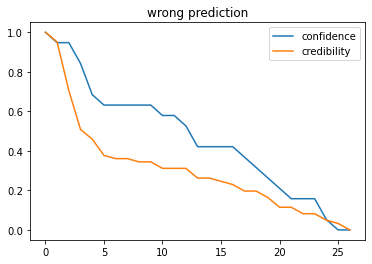

In [164]:
df=tt.loc[0, 'df']
util.plot_conf_cred(df[~df.verdict].sort_values(by=['confidence','credibility']), title='wrong prediction')
df[~df.verdict].sort_values(by=['confidence','credibility']).head()
# df[~df.verdict].sort_values(by=['confidence','credibility'])

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
82,[],0.91791,0.089552,0.1,"[(0.08208955223880597, 0), (0.0895522388059701...",False,0.500000,0,2,0.285714,0.038462,2,3,0
116,[],0.91791,0.097015,0.1,"[(0.09701492537313433, 0), (0.0820895522388059...",False,0.500000,0,2,0.571429,1.000000,0,0,1
94,[0],0.91791,0.100746,0.1,"[(0.10074626865671642, 0), (0.0820895522388059...",True,0.470588,0,2,0.571429,1.000000,0,2,0
134,[1],0.91791,0.100746,0.1,"[(0.08208955223880597, 0), (0.1007462686567164...",True,0.529412,0,2,0.285714,1.000000,0,1,1
286,[0],0.91791,0.100746,0.1,"[(0.10074626865671642, 0), (0.0820895522388059...",True,0.470588,0,2,0.571429,0.051282,1,2,0


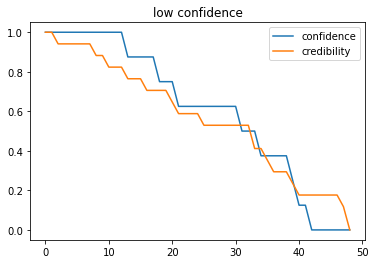

In [165]:
util.plot_conf_cred(df[df.confidence < 0.95].sort_values(by=['confidence','credibility']), title='low confidence')
df[df.confidence < 0.95].sort_values(by=['confidence','credibility']).head()
# df[df.confidence < 0.95].sort_values(by=['confidence','credibility'])

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,conformal_predictor,nonconformity,method,model,instance_of_model,df
0,0.984347,0.497817,0.9325,0.005,0.995,0.9325,0.0,signal_with_header_for_orange,False,logistic regression,InductiveClassifier (InverseProbability (logis...,InverseProbability (logistic regression),,LogisticRegressionClassifier(skl_model=Logisti...,InductiveClassifier (InverseProbability (logis...,classes confidence credibility eps \ 0...
1,0.984347,0.497817,0.9325,0.005,0.995,0.9325,0.0,signal_with_header_for_orange,False,logistic regression,InductiveClassifier (InverseProbability (logis...,InverseProbability (logistic regression),,LogisticRegressionClassifier(skl_model=Logisti...,InductiveClassifier (InverseProbability (logis...,classes confidence credibility eps \ 0...
2,0.984347,0.497817,0.9325,0.005,0.995,0.9325,0.0,signal_with_header_for_orange,False,logistic regression,InductiveClassifier (InverseProbability (logis...,InverseProbability (logistic regression),,LogisticRegressionClassifier(skl_model=Logisti...,InductiveClassifier (InverseProbability (logis...,classes confidence credibility eps \ 0...


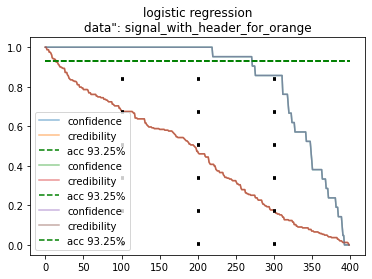

In [128]:
np.random.seed(42)


train, test = next(cp.evaluation.RandomSampler(tab_signal,2,1))
train, calibrate = next(cp.evaluation.RandomSampler(train,2,1))

cc=cp.classification.InductiveClassifier(cp.nonconformity.InverseProbability(Orange.classification.LogisticRegressionLearner()))
tt = run_experiments(cc, train, test, calibrate, times=3)

plot_experiments(tt)
tt

Notice LR doesn't change, but RF below does

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,conformal_predictor,nonconformity,method,model,instance_of_model,df
0,0.966604,0.633946,0.93,0.0,0.9725,0.9025,0.0275,signal_with_header_for_orange,False,random forest,InductiveClassifier (InverseProbability (rando...,InverseProbability (random forest),,RandomForestClassifier(skl_model=RandomForestC...,InductiveClassifier (InverseProbability (rando...,classes confidence credibility eps \ 0...
1,0.959636,0.677509,0.915,0.0,0.9725,0.8875,0.0275,signal_with_header_for_orange,False,random forest,InductiveClassifier (InverseProbability (rando...,InverseProbability (random forest),,RandomForestClassifier(skl_model=RandomForestC...,InductiveClassifier (InverseProbability (rando...,classes confidence credibility eps \ 0...
2,0.96472,0.662351,0.9475,0.0,0.895,0.8425,0.105,signal_with_header_for_orange,False,random forest,InductiveClassifier (InverseProbability (rando...,InverseProbability (random forest),,RandomForestClassifier(skl_model=RandomForestC...,InductiveClassifier (InverseProbability (rando...,classes confidence credibility eps \ 0...


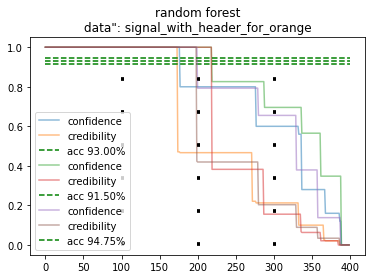

In [127]:
np.random.seed(42)


train, test = next(cp.evaluation.RandomSampler(tab_signal,2,1))
train, calibrate = next(cp.evaluation.RandomSampler(train,2,1))

cc=cp.classification.InductiveClassifier(cp.nonconformity.InverseProbability(Orange.classification.RandomForestLearner()))
tt = run_experiments(cc, train, test, calibrate, times=3)

plot_experiments(tt)
tt

-----

-----